# Convert Kinetics Library to Training Reactions Script

Specify the kinetics library name below and run the script.  It automatically overwrites the training reactions files it needs to.  Then you should commit those files.

This script only trains safely.  In other words, if a single match from an RMG family is found, a training reaction is created.  Sometimes, there are no matches from RMG reaction families, or multiple matches.  This indicates an error that requires manual fixing, and a printout is given in the script.

In [1]:
libraryName = 'C3H3_recomb_part'
compareKinetics = True

In [2]:
from rmgpy.data.rmg import RMGDatabase
from rmgpy.chemkin import saveChemkinFile, saveSpeciesDictionary
from rmgpy.rmg.model import Species
from rmgpy import settings
from IPython.display import display, HTML, Image
import itertools
from base64 import b64encode
if compareKinetics:
    import numpy as np
    import matplotlib.pyplot as plt
    from io import BytesIO


## load lib_rxn

In [3]:
database = RMGDatabase()
database.load(
    path = settings['database.directory'], 
    thermoLibraries = ['FFCM1(-)','C4H6_carbene','BurkeH2O2','primaryThermoLibrary','DFT_QCI_thermo','CBS_QB3_1dHR'], # can add others if necessary
    kineticsFamilies = 'default', 
    reactionLibraries = [libraryName], 
    kineticsDepositories = 'all'
)
# if we want accurate kinetics comparison, add existing training reactions and fill tree by averaging
if compareKinetics:
    for family in database.kinetics.families.values():
        family.addKineticsRulesFromTrainingSet(thermoDatabase=database.thermo)
        family.fillKineticsRulesByAveragingUp(verbose=True)

/home/jimchu10/anaconda2/envs/rmg_env/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## generate fam_rxn, spec replacement and get reactionDict


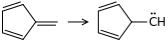


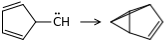


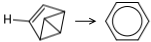

In [4]:
reactionDict = {}
kineticLibrary = database.kinetics.libraries[libraryName]

# html table settings
full = 12
half = full / 2

for index, entry in kineticLibrary.entries.iteritems():
    lib_rxn = entry.item
    lib_rxn.kinetics = entry.data 
    lib_rxn.index = entry.index
    lib_rxn.kinetics.comment = entry.label # Assign the entry's label to the comment
    # Let's make RMG try to generate this reaction from the families!
    fam_rxn_list = []
    
    #get list of all possible resonance structures of reactant molecules
    if len(lib_rxn.reactants) > 1:
        rxt_resonances = [rxt.molecule for rxt in lib_rxn.reactants]
        rxts_cross = list(itertools.product(*rxt_resonances))
        rxts_cross = [list(cross) for cross in rxts_cross]
    else:
        rxts_cross = [[mol] for mol in lib_rxn.reactants[0].molecule] #should have only one reactant
    
    #use families to try find reactions
    for rxts_mol in rxts_cross:
        pdts_mol = [spc.molecule[0] for spc in lib_rxn.products] #do we also need to cross through products.mol
        fam_rxn_list.extend(database.kinetics.generateReactionsFromFamilies(
                        reactants=rxts_mol, products=pdts_mol))

    if len(fam_rxn_list) == 1:
        fam_rxn = fam_rxn_list[0]

        # danger: the fam_rxn may have switched the reactants with products
        # fam_rxn is survived from def filterReactions
        # so it's matched with lib_rxn only we have to 
        # determine the direction
        lib_reactants = [r for r in lib_rxn.reactants]        
        fam_reactants = [r for r in fam_rxn.reactants]
        for lib_reactant in lib_reactants:
            for fam_reactant in fam_reactants:
                if lib_reactant.isIsomorphic(fam_reactant):
                    fam_reactants.remove(fam_reactant)
                    break

        lib_products = [r for r in lib_rxn.products]        
        fam_products = [r for r in fam_rxn.products]
        for lib_product in lib_products:
            for fam_product in fam_products:
                if lib_product.isIsomorphic(fam_product):
                    fam_products.remove(fam_product)
                    break

        forward = not (len(fam_reactants) != 0 or len(fam_products) != 0)
        # find the labeled atoms using family and reactants & products from fam_rxn
        family_database = database.kinetics.families[fam_rxn.family]
        family_database.addAtomLabelsForReaction(fam_rxn)
        # species replacement so that labeledAtoms is retored
        if forward:
            lib_rxn.reactants = fam_rxn.reactants
            lib_rxn.products = fam_rxn.products
        else:
            lib_rxn.reactants = fam_rxn.products
            lib_rxn.products = fam_rxn.reactants
        if fam_rxn.family in reactionDict:
            reactionDict[fam_rxn.family].append(lib_rxn)
        else:
            reactionDict[fam_rxn.family] = [lib_rxn]
            
        template = database.kinetics.families[fam_rxn.family].getReactionTemplate(fam_rxn)
        
        templateSize = len(template)
        # html table currently uses a 12 column setup, so templates with 5 groups will break the table
        assert templateSize < 5
        
        if compareKinetics:
            # check what the current kinetics for this template are
            newKinetics = lib_rxn.kinetics
            oldKinetics = database.kinetics.families[fam_rxn.family].getKineticsForTemplate(template, degeneracy=fam_rxn.degeneracy)[0]
            # evaluate kinetics
            tlistinv = np.linspace(1000/1500, 1000/300, num=10)
            tlist = 1000 * np.reciprocal(tlistinv)
            newklist = np.log10(np.array([newKinetics.getRateCoefficient(t) for t in tlist]))
            oldklist = np.log10(np.array([oldKinetics.getRateCoefficient(t) for t in tlist]))
            # create plot
            plt.cla()
            plt.plot(tlistinv, newklist, label='New')
            plt.plot(tlistinv, oldklist, label='Current')
            plt.legend()
            plt.xlabel('1000/T')
            plt.ylabel('log(k)')
            fig = BytesIO()
            plt.savefig(fig, format='png')
            fig.seek(0)
            figdata = b64encode(fig.getvalue())
            fig.close()
        
        # format output using html
        html = ['<table style="width:100%;table-layout:fixed;"><tr>']
        html += ['<th colspan="{0}" style="color:green">One RMG match for this reaction</th>'.format(full)]
        html += ['</tr><tr>']
        html += ['<td colspan="{0}"><img src="data:image/png;base64,{1}"></td>'.format(full, b64encode(fam_rxn._repr_png_()))]
        html += ['</tr><tr>']
        html += ['<th colspan="{0}">Reactant SMILES</th>'.format(half)]
        html += ['<td colspan="{0}">{1}</td>'.format(half, ' + '.join([reactant.molecule[0].toSMILES() for reactant in lib_rxn.reactants]))]
        html += ['</tr><tr>']
        html += ['<th colspan="{0}">Product SMILES</th>'.format(half)]
        html += ['<td colspan="{0}">{1}</td>'.format(half, ' + '.join([product.molecule[0].toSMILES() for product in lib_rxn.products]))]
        html += ['</tr><tr>']
        html += ['<th colspan="{0}">Matched Family</th>'.format(half)]
        html += ['<td colspan="{0}">{1}</td>'.format(half, fam_rxn.family)]
        html += ['</tr><tr>']
        html += ['<th colspan="{0}">Matched Template</th>'.format(half)]
        html += ['<td colspan="{0}">{1}</td>'.format(half, [entry.label for entry in template])]
        html += ['</tr><tr>']
        for entry in template:
            html += ['<td colspan="{0}">{1}</td>'.format(full/templateSize, entry.label)]
        html += ['</tr><tr>']
        for entry in template:
            html += ['<td colspan="{0}"><img src="data:image/png;base64,{1}"></td>'.format(full/templateSize, b64encode(entry.item._repr_png_()))]
        if compareKinetics:
            if not forward:
                html += ['</tr><tr>']
                html += ['<th colspan="{0}" style="color:red;text-align:center">Note: Training reaction written in opposite direction from reaction family.'.format(full)]
            html += ['</tr><tr>']
            html += ['<td colspan="{0}"><strong>New Kinetics:</strong><br>{1}<br><br><strong>Current Kinetics</strong><br>{2}</td>'.format(half, newKinetics, oldKinetics)]
            html += ['<td colspan="{0}"><img src="data:image/png;base64,{1}"></td>'.format(half, figdata)]
        html += ['</tr></table>']
        
        display(HTML(''.join(html)))
    elif len(fam_rxn_list) == 0:
        html = ['<table style="width:100%;table-layout:fixed;"><tr>']
        html += ['<th colspan="2" style="color:red">Sad :( There are no matches.  This is a magic reaction or has chemistry that should be made into a new reaction family</th>']
        html += ['</tr><tr>']
        html += ['<td colspan="2">{0}</td>'.format(str(lib_rxn))]
        html += ['</tr><tr>']
        html += ['<td colspan="2"><img src="data:image/png;base64,{0}"></td>'.format(b64encode(lib_rxn._repr_png_()))]
        html += ['</tr><tr>']
        html += ['<th>Reactant SMILES</th>']
        html += ['<td>{0}</td>'.format(' + '.join([reactant.molecule[0].toSMILES() for reactant in lib_rxn.reactants]))]
        html += ['</tr><tr>']
        html += ['<th>Product SMILES</th>']
        html += ['<td>{0}</td>'.format(' + '.join([product.molecule[0].toSMILES() for product in lib_rxn.products]))]
        html += ['</tr></table>']
        
        display(HTML(''.join(html)))
    else:
        if compareKinetics: oldKinetics = []
        lib_reactant = lib_rxn.reactants[0]
        forward = True
        for i, rxn in enumerate(fam_rxn_list):
            # determine direction of family reaction
            fam_reactants = list(rxn.reactants)
            for fam_reactant in fam_reactants:
                if lib_reactant.isIsomorphic(fam_reactant):
                    break
            else:
                forward = False
            
            # find the labeled atoms using family and reactants & products from fam_rxn
            family_database = database.kinetics.families[rxn.family]
            family_database.addAtomLabelsForReaction(rxn)
            template = database.kinetics.families[rxn.family].getReactionTemplate(rxn)
            templateSize = len(template)
            
            if compareKinetics:
                oldKinetics.append(database.kinetics.families[rxn.family].getKineticsForTemplate(template, degeneracy=rxn.degeneracy)[0])
            
            if i == 0:        
                html = ['<table style="width:100%;table-layout:fixed;"><tr>']
                html += ['<th colspan="{0}" style="color:blue">There are multiple RMG matches for this reaction. You have to manually create this training reaction.</th>'.format(full)]
                html += ['</tr><tr>']
                html += ['<td colspan="{0}">{1}</td>'.format(full, str(lib_rxn))]
                html += ['</tr><tr>']
                html += ['<th colspan="{0}">Reactant SMILES</th>'.format(half)]
                html += ['<td colspan="{0}">{1}</td>'.format(half, ' + '.join([reactant.molecule[0].toSMILES() for reactant in lib_rxn.reactants]))]
                html += ['</tr><tr>']
                html += ['<th colspan="{0}">Product SMILES</th>'.format(half)]
                html += ['<td colspan="{0}">{1}</td>'.format(half, ' + '.join([product.molecule[0].toSMILES() for product in lib_rxn.products]))]
                html += ['</tr><tr>']
            
            html += ['<th colspan="{0}">Match #{1} - For the following resonance form of the reaction:</th>'.format(full, i + 1)]
            html += ['</tr><tr>']
            html += ['<td colspan="{0}"><img src="data:image/png;base64,{1}"></td>'.format(full, b64encode(rxn._repr_png_()))]
            html += ['</tr><tr>']
            html += ['<th colspan="{0}">Matched Family</th>'.format(half)]
            html += ['<td colspan="{0}">{1}</td>'.format(half, rxn.family)]
            html += ['</tr><tr>']
            html += ['<th colspan="{0}">Matched Template</th>'.format(half)]
            html += ['<td colspan="{0}">{1}</td>'.format(half, [entry.label for entry in template])]
            html += ['</tr><tr>']
            for entry in template:
                html += ['<td colspan="{0}">{1}</td>'.format(full/templateSize, entry.label)]
            html += ['</tr><tr>']
            for entry in template:
                html += ['<td colspan="{0}"><img src="data:image/png;base64,{1}"></td>'.format(full/templateSize, b64encode(entry.item._repr_png_()))]
            html += ['</tr><tr>']
        
        if compareKinetics:
            newKinetics = lib_rxn.kinetics
            # evaluate kinetics
            tlistinv = np.linspace(1000/1500, 1000/300, num=10)
            tlist = 1000 * np.reciprocal(tlistinv)
            newklist = np.log10(np.array([newKinetics.getRateCoefficient(t) for t in tlist]))
            oldklist = []
            for kinetics in oldKinetics:
                oldklist.append(np.log10(np.array([kinetics.getRateCoefficient(t) for t in tlist])))
            # create plot
            plt.cla()
            plt.plot(tlistinv, newklist, label='New')
            for i, k in enumerate(oldklist):
                plt.plot(tlistinv, k, label='Match #{0}'.format(i + 1))
            plt.legend()
            plt.xlabel('1000/T')
            plt.ylabel('log(k)')
            fig = BytesIO()
            plt.savefig(fig, format='png')
            fig.seek(0)
            figdata = b64encode(fig.getvalue())
            fig.close()
            
            if not forward:
                html += ['</tr><tr>']
                html += ['<th colspan="{0}" style="color:red;text-align:center">Note: Training reaction written in opposite direction from reaction family.'.format(full)]
            html += ['</tr><tr><td colspan="{0}">'.format(half)]
            html += ['<strong>New Kinetics:</strong><br>{0}'.format(newKinetics)]
            for i, kinetics in enumerate(oldKinetics):
                html += ['<br><br><strong>Match #{0} Kinetics:</strong><br>{1}'.format(i + 1, kinetics)]
            html += ['</td><td colspan="{0}"><img src="data:image/png;base64,{1}"></td>'.format(half, figdata)]
        
        html += ['</tr></table>']
        
        display(HTML(''.join(html)))


In [6]:
for familyName in reactionDict:
    print 'Adding training reactions for family: ' + familyName
    kineticFamily = database.kinetics.families[familyName]
    trainingDatabase = None
    for depository in kineticFamily.depositories:
            if depository.label.endswith('training'):
                trainingDatabase = depository
                break
    reactions = reactionDict[familyName]
    print 'reactions.py previously has {} rxns. Now adding {} new rxn(s).'.format(len(trainingDatabase.entries.values()), len(reactions))
    print '================='
    kineticFamily.saveTrainingReactions(reactions, shortDesc='Training reaction from kinetics library: {0}'.format(libraryName))

Adding training reactions for family: R_Recombination
reactions.py previously has 34 rxns. Now adding 3 new rxn(s).


# How saveTrainingReaction works

This part of the script is commented and should not be run.  It serves only to demonstrate how the code for saving the training reactions works.

## get speciesDict

### load existing species as an intial speciesDict

In [ ]:
# import os
# from rmgpy.data.base import Database

# training_path = os.path.join(settings['database.directory'], \
#                              'kinetics', 'families', 'R_Addition_MultipleBond', 'training')

# dictionary_file = os.path.join(training_path, 'dictionary.txt')

# # Load the existing set of the species of the training reactions
# speciesDict = Database().getSpecies(dictionary_file)

### for one family check uniqueness of each species in the lib_rxns

In [ ]:
# familyName = 'R_Addition_MultipleBond'
# print 'Adding training reactions for family: ' + familyName
# kineticFamily = database.kinetics.families[familyName]
# reactions = reactionDict[familyName]

# for rxn in reactions:
#     for spec in (rxn.reactants + rxn.products):
#         for ex_spec_label in speciesDict:
#             ex_spec = speciesDict[ex_spec_label]
#             if ex_spec.molecule[0].getFormula() != spec.molecule[0].getFormula():
#                 continue
#             else:
#                 spec_labeledAtoms = spec.molecule[0].getLabeledAtoms()
#                 ex_spec_labeledAtoms = ex_spec.molecule[0].getLabeledAtoms()
#                 initialMap = {}
#                 try:
#                     for atomLabel in spec_labeledAtoms:
#                         initialMap[spec_labeledAtoms[atomLabel]] = ex_spec_labeledAtoms[atomLabel]
#                 except KeyError:
#                     # atom labels did not match, therefore not a match
#                     continue
#                 if spec.molecule[0].isIsomorphic(ex_spec.molecule[0],initialMap):
#                     spec.label = ex_spec.label
#                     break
#         else:# no isomorphic existing species found
#             spec_formula = spec.molecule[0].getFormula()
#             if spec_formula not in speciesDict:
#                 spec.label = spec_formula
#             else:
#                 index = 2
#                 while (spec_formula + '-{}'.format(index)) in speciesDict:
#                     index += 1
#                 spec.label = spec_formula + '-{}'.format(index)
#             speciesDict[spec.label] = spec

## save to files

Save reactionDict to reactions.py and speciesDict to dictionary.txt

In [ ]:
# # try to append 
# training_file = open(os.path.join(settings['database.directory'], 'kinetics', 'families', \
#             kineticFamily.label, 'training', 'reactions_test.py'), 'a')

# training_file.write("\n\n")

In [ ]:
# # find the largest reaction index
# for depository in kineticFamily.depositories:
#     if depository.label.endswith('training'):
#         break
# else:
#     logging.info('Could not find training depository in family {0}.'.format(kineticFamily.label))
#     logging.info('Starting a new one')
#     depository = KineticsDepository()
#     kineticFamily.depositories.append(depository)

# trainingDatabase = depository
# indices = [entry.index for entry in trainingDatabase.entries.values()]
# if indices:
#     maxIndex = max(indices)
# else:
#     maxIndex = 0

In [ ]:
# # save reactions.py
# from rmgpy.data.base import Entry
# for i, reaction in enumerate(reactions):    
#     entry = Entry(
#         index = maxIndex+i+1,
#         label = str(reaction),
#         item = reaction,
#         data = reaction.kinetics,
#         reference = None,
#         referenceType = '',
#         shortDesc = unicode(''),
#         longDesc = unicode(''),
#         rank = 3,
#         )
#     print reaction
#     kineticFamily.saveEntry(training_file, entry)

# training_file.close()

In [ ]:
# # save dictionary.txt
# directory_test_file = os.path.join(training_path, 'directory_test.txt')
# with open(directory_test_file, 'w') as f:
#     for label in speciesDict.keys():
#         f.write(speciesDict[label].molecule[0].toAdjacencyList(label=label, removeH=False))
#         f.write('\n')
# f.close()